## Introduction

This notebook assumes you already have downloaded the Credit Card Fraud Detection dataset from Kaggle, which is available at https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.

The dataset has the following columns:

- `Time` (transaction time in seconds) 
- `V1` ... `V_28` (PCA components)
- `value` (transaction amount)
- `Class` (binary target, 0=not fraud, 1=fraud)

We will:

1. Split the data (stratified) into train/test.
2. Train four models using common available algorithms and reasonable default hyperparameters.
3. Evaluate the efectiveness of SMOTE as a rebalancing tool in this context.
4. Evaluate with classification report, ROC AUC and PR AUC.
5. Show comparative plots and a summary table.


## 1. Importing the required libraries

In [2]:
# Basic packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Data pre-processing packages
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Machine learning packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Note: Make sure xgboost and lightgbm are installed.

Assuming the data is prepared, we load it into a pandas DataFrame for further exploration.

## 2. Loading the Data

In [3]:
# df = pd.read_csv(os.path.join("data", "bank_transactions_processed.csv"))
df = pd.read_csv("/home/gabriel/Downloads/creditcard.csv")
df = df.rename(columns={"Class": "is_fraud"})
display(df.sample(5))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,is_fraud
262879,160691.0,-1.580623,-1.330106,-0.585905,2.637693,-2.875413,1.224846,2.897033,0.181003,-0.694119,...,0.716620,0.561464,2.044144,-0.154172,-0.473960,-0.318586,-0.128678,0.216670,877.57,0
69006,53225.0,1.113727,-0.137286,0.774705,0.627193,-0.890872,-0.621748,-0.339806,0.066980,0.191773,...,0.082341,0.103785,-0.007521,0.536976,0.229376,0.316909,-0.033221,0.015528,39.90,0
237758,149377.0,2.276279,-0.490496,-2.423603,-0.861238,0.140002,-1.680452,0.369358,-0.565380,-0.933704,...,0.487906,1.420626,-0.128378,1.160516,0.686269,0.250743,-0.103249,-0.085479,10.00,0
280687,169686.0,-2.489464,2.458917,0.295697,-0.733634,-0.132705,2.466194,-3.426810,-7.051994,-1.273054,...,-3.890751,0.759392,0.335384,-0.266866,0.248747,-0.463161,-0.149713,0.112519,9.99,0
75560,56124.0,-1.974510,0.284430,-0.394794,-1.022796,0.011504,0.821796,0.411709,1.135241,-0.246887,...,0.208659,0.728154,0.497301,-0.874355,-0.671107,0.967181,0.158078,-0.182513,126.38,0


## 3. Exploratory Data Analysis (EDA)

First, let's get a brief checking on missing values, dtypes and descriptive statistics.

In [5]:
# Checking for missing values
print(df.isna().sum())

Time        0
V1          0
V2          0
V3          0
V4          0
V5          0
V6          0
V7          0
V8          0
V9          0
V10         0
V11         0
V12         0
V13         0
V14         0
V15         0
V16         0
V17         0
V18         0
V19         0
V20         0
V21         0
V22         0
V23         0
V24         0
V25         0
V26         0
V27         0
V28         0
Amount      0
is_fraud    0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time      284807 non-null  float64
 1   V1        284807 non-null  float64
 2   V2        284807 non-null  float64
 3   V3        284807 non-null  float64
 4   V4        284807 non-null  float64
 5   V5        284807 non-null  float64
 6   V6        284807 non-null  float64
 7   V7        284807 non-null  float64
 8   V8        284807 non-null  float64
 9   V9        284807 non-null  float64
 10  V10       284807 non-null  float64
 11  V11       284807 non-null  float64
 12  V12       284807 non-null  float64
 13  V13       284807 non-null  float64
 14  V14       284807 non-null  float64
 15  V15       284807 non-null  float64
 16  V16       284807 non-null  float64
 17  V17       284807 non-null  float64
 18  V18       284807 non-null  float64
 19  V19       284807 non-null  float64
 20  V20 

In [6]:
display(df.describe())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [11]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,is_fraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


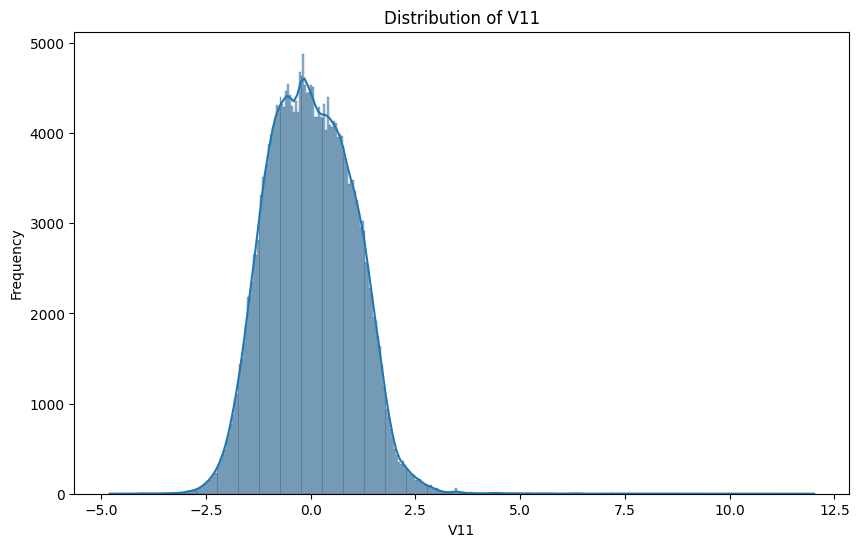

In [54]:
# Plot the distribution of "Amount" variable
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='V11', kde=True)
plt.title('Distribution of V11')
plt.xlabel('V11')
plt.ylabel('Frequency')
plt.show()

Great! Our data is normalized, encoded and there's no missing values in the dataset.

Also, the time feature seems to be encoded according to the number of seconds since the first transaction.

Checking the correlations of the dataset:

In [15]:
df.corr().style.background_gradient(cmap='coolwarm')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,is_fraud
Time,1.000000,0.117396,-0.010593,-0.419618,-0.105260,0.173072,-0.063016,0.084714,-0.036949,-0.008660,0.030617,-0.247689,0.124348,-0.065902,-0.098757,-0.183453,0.011903,-0.073297,0.090438,0.028975,-0.050866,0.044736,0.144059,0.051142,-0.016182,-0.233083,-0.041407,-0.005135,-0.009413,-0.010596,-0.012323
V1,0.117396,1.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.227709,-0.101347
V2,-0.010593,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.531409,0.091289
V3,-0.419618,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.210880,-0.192961
V4,-0.105260,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.098732,0.133447
V5,0.173072,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.386356,-0.094974
V6,-0.063016,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.215981,-0.043643
V7,0.084714,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.397311,-0.187257
V8,-0.036949,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.103079,0.019875
V9,-0.008660,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.044246,-0.097733


The correlation matrix shows that there is not a strong correlation between the features, what would not be a problem for decision tree based models.

Now, let's verify the distribution of the target variable.

In [55]:
display(df['is_fraud'].value_counts())
px.bar(df['is_fraud'].value_counts(), color=df['is_fraud'].value_counts().index)

is_fraud
0    284315
1       492
Name: count, dtype: int64

In [56]:
(len(df[df['is_fraud'] == 1]) / len(df['is_fraud'])) * 100

0.1727485630620034

⚠️ As expected, the dataset is highly imbalanced — only 0.17% of transactions are fraudulent.
We'll handle this imbalance in the next steps.

## 4. Preparing data for training

First we have to split our dataset in train and test sets to avoid data leakage and overfitting.

Given the severe class imbalance, we use some techniques, such as SMOTE - Synthetic Minority Oversampling Technique - and others, to ensure a balanced training.

### Spliting data into train and test
Setting our explanatory variables:

In [57]:
X = df.drop(['is_fraud'], axis=1)

Setting our response variable:

In [58]:
y = df['is_fraud']

Splitting our data into train and test sets. We set 20% of the data as the test set and 80% as the train set. We also use `stratify=y` to ensure that the test set has the same distribution of classes as the train set.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Checking the fraud ratio in train and test datasets:

In [60]:
# Print sizes
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train fraud ratio:', y_train.mean(), 'Test fraud ratio:', y_test.mean())

Train shape: (227845, 30) Test shape: (56962, 30)
Train fraud ratio: 0.001729245759178389 Test fraud ratio: 0.0017204452090867595


The stratify parameter worked fine and the proportions of fraud and non-fraud transactions were preserved in both the training and testing sets.

Runnning the resampling (oversampling) method:

## 5. Creating predictive models for fraud detection in bank transactions

We train multiple machine learning models, widely used in fraud detection:

- Logistic Regression
- Random Forest
- XGBoost
- LightGBM

Each model is evaluated based on its ability to correctly classify fraudulent transactions while minimizing false positives.


### Model Evaluation

As fraud is rarely an accuracy problem, we use a combination of the following metrics to assess model performance:

- Precision
- Recall
- F1-Score
- AUC-ROC
- AUC-PR (even better than ROC)

Because fraud detection is a highly imbalanced issue, **precision** is more important than overall accuracy. Moreover, the best model should balance sensitivity (detecting frauds) and specificity (avoiding false alarms), so we give a higher attention to **Confusion Matrix** and **F1-Score** reports to ensure good performance on both fronts. This ensures that we minimize false positives while maintaining high recall for fraud detection, which is critical in real-world fraud detection systems, especially in financial applications where false positives can lead to customer dissatisfaction and operational costs, and false negatives can result in financial losses.


### Auxiliary function

First of all, let's define a helper function to evaluate our models:

In [61]:
# Print basic metrics
def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("PR AUC:", average_precision_score(y_test, y_prob))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Plotting helper: ROC and PR for multiple models
def plot_roc_pr(models, X_test, y_test, figsize=(12,5)):
    """Plot ROC and Precision-Recall for a dict of fitted models.
    models: dict{name: model}
    """
    print("Plotting ROC curves...")
    plt.figure(figsize=figsize)
    # ROC subplot
    plt.subplot(1,2,1)
    for name, model in models.items():
        try:
            RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
        except Exception as e:
            print(f"Could not plot ROC for {name}: {e}")
    plt.title('ROC Curves')
    plt.legend()

    # PR subplot
    plt.subplot(1,2,2)
    for name, model in models.items():
        try:
            PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=name)
        except Exception as e:
            print(f"Could not plot PR for {name}: {e}")
    plt.title('Precision-Recall Curves')
    plt.tight_layout()
    plt.show()

### 5.1 Logistic Regression

We use `class_weight='balanced'` parameter to handle the class imbalance.

In [62]:
logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)
logreg.fit(X_train, y_train)
print("Logistic Regression model trained successfully.")
print(f"Training samples: {len(X_train)}, Fraud rate: {y_train.mean():.4f}")
print(f"Test samples: {len(X_test)}, Fraud rate: {y_test.mean():.4f}")
eval_model(logreg, X_test, y_test)

Logistic Regression model trained successfully.
Training samples: 227845, Fraud rate: 0.0017
Test samples: 56962, Fraud rate: 0.0017
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

ROC AUC: 0.9723337386445856
PR AUC: 0.7239824826684915
Confusion Matrix:
[[55261  1603]
 [    8    90]]


> Using SMOTE to balance the dataset:

In [66]:
from collections import Counter

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Training set class distribution after SMOTE: {Counter(y_train_resampled)}")

logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)
logreg.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression model trained successfully.")
print(f"Training samples: {len(X_train_resampled)}, Fraud rate: {y_train_resampled.mean():.4f}")
print(f"Test samples: {len(X_test)}, Fraud rate: {y_test.mean():.4f}")
eval_model(logreg, X_test, y_test)

Training set class distribution after SMOTE: Counter({0: 227451, 1: 227451})
Logistic Regression model trained successfully.
Training samples: 454902, Fraud rate: 0.5000
Test samples: 56962, Fraud rate: 0.0017
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.90      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962

ROC AUC: 0.9752037263273345
PR AUC: 0.7292230135977045
Confusion Matrix:
[[56178   686]
 [   10    88]]


## 5.2 Random Forest

Using Random Forest we can set `class_weight='balanced_subsample` to handle the imbalance data.

In [ ]:
import timeit

stmt = '''
rf = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', # Adjusts weights inversely proportional to frequency
    n_jobs=-1, 
    random_state=42
)
rf.fit(X_train, y_train)
eval_model(rf, X_test, y_test)
'''

print(f'\nTime of training: {timeit.timeit(stmt, number=1, globals=globals())} seconds.')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.952908497036969
PR AUC: 0.8541999432510914
Confusion Matrix:
[[56861     3]
 [   25    73]]
Time of training: 43.65405557300255 seconds.


In [72]:
stmt = '''

print(f"Training set class distribution after SMOTE: {Counter(y_train_resampled)}")

rf = RandomForestClassifier(
    n_estimators=100, 
    #class_weight='balanced', # Adjusts weights inversely proportional to frequency
    n_jobs=-1, 
    random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)
eval_model(rf, X_test, y_test)'''

print(f'\nTime of training: {timeit.timeit(stmt, number=1, globals=globals())} seconds')

Training set class distribution after SMOTE: Counter({0: 227451, 1: 227451})
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9644234399584257
PR AUC: 0.8740809794187884
Confusion Matrix:
[[56847    17]
 [   17    81]]
Time of training: 168.69285158799903 seconds


As we can see, using SMOTE in a decision tree based model doesn't improve the results. Moreover, it dramatically degrades the performance of the model.

### 5.3 XGBoost

XGBoost is a powerful gradient boosting framework that often provides excellent performance for tabular data like transaction datasets.

It's particularly effective for this type of binary classification problem due to its ability to handle imbalanced data and capture complex feature interactions effectively.

To deal with the class imbalance in our fraud detection dataset, we'll use the `scale_pos_weight` parameter to give higher weight to the minority class (fraudulent transactions).

The `scale_pos_weight` parameter is calculated as the ratio of negative samples to positive samples to balance the classes.

In [19]:
# Calculating the scale_pos_weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale = neg / pos
print(f"Negative samples: {neg}, Positive samples: {pos}")
print(f"Scale factor: {scale:.2f}")
print(f"scale_pos_weight for XGBoost: {scale:.2f}")

Negative samples: 227451, Positive samples: 394
Scale factor: 577.29
scale_pos_weight for XGBoost: 577.29


This means XGBoost will penalize false negatives 69 times more than false positives.

Training and evaluating the model:

In [81]:
xgb = XGBClassifier(
    scale_pos_weight=scale, # Equilibra o treinamento
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train, y_train)
eval_model(xgb, X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1971
           1       0.00      0.00      0.00        29

    accuracy                           0.98      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.97      0.98      0.98      2000

ROC AUC: 0.6074808866495215
PR AUC: 0.02139161839820279
Confusion Matrix:
[[1966    5]
 [  29    0]]


In [20]:
xgb = XGBClassifier(
    scale_pos_weight=scale, # Equilibra o treinamento
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train, y_train)
eval_model(xgb, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9682378578893572
PR AUC: 0.8800038893818777
Confusion Matrix:
[[56853    11]
 [   16    82]]


### 5.4 LightGBM

We train LightGBM with `is_unbalance=True` or `scale_pos_weight` depending on API. Using `is_unbalance=True` makes LightGBM internally treat the classes as unbalanced. We can also provide `class_weight` or `scale_pos_weight` if desired.

In [82]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    scale_pos_weight=scale, # Equilibra o treinamento
    verbose=-1,
    random_state=42
)

lgbm.fit(X_train, y_train)
print('LightGBM trained')
eval_model(lgbm, X_test, y_test)

LightGBM trained
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1971
           1       0.00      0.00      0.00        29

    accuracy                           0.98      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.97      0.98      0.98      2000

ROC AUC: 0.5041200860756836
PR AUC: 0.017795821728797193
Confusion Matrix:
[[1966    5]
 [  29    0]]


In [22]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    scale_pos_weight=scale, # Equilibra o treinamento
    verbose=-1,
    random_state=42
)

lgbm.fit(X_train, y_train)
print('LightGBM trained')
eval_model(lgbm, X_test, y_test)

LightGBM trained
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.87      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962

ROC AUC: 0.9124603062947183
PR AUC: 0.055109197735150904
Confusion Matrix:
[[55544  1320]
 [   13    85]]


## 6. Comparative summary

In [75]:
models = {
    'XGBoost': xgb,
    'LightGBM': lgbm,
    'Random Forest': rf,
    'Logistic Regression': logreg,
}

results = []
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        try:
            y_score = model.decision_function(X_test)
            y_prob = 1 / (1 + np.exp(-y_score))
        except Exception:
            y_prob = model.predict(X_test)
    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob)
    results.append({'Model': name, 'ROC_AUC': roc, 'PR_AUC': pr})

summary_df = pd.DataFrame(results).sort_values('PR_AUC', ascending=False).reset_index(drop=True)
print(summary_df)

                 Model   ROC_AUC    PR_AUC
0              XGBoost  0.567540  0.019809
1             LightGBM  0.568904  0.018467
2        Random Forest  0.475288  0.015365
3  Logistic Regression  0.488060  0.014218


**Explanation:**
- We rank models by PR_AUC (average precision) because Precision-Recall is more informative on imbalanced datasets.

-----

Conclusion

As we can see, XGBoost performs well on this dataset. It achieves good ROC AUC and PR AUC scores, and the confusion matrix shows a reasonable balance between precision and recall for fraud detection. This makes it a strong candidate for production use in fraud detection systems.